# Scenes
__________________________________

## Working with Scenes
____________________________

[**Scenes**](https://docs.descarteslabs.com/guides/scenes.html) is a tool in the Descartes Labs platform to search and access imagery over a wide variety of data sources. Below we show how to define an area of interest, search for imagery, download the image, and start doing analysis. First let's import the Descartes Labs library and define a place of interest.

You can run the following cells using `Shift-Enter`.

In [1]:
# keep logging quiet
import logging
logging.getLogger().setLevel(logging.INFO)
logging.captureWarnings(True)

In [2]:
# import packages
import descarteslabs as dl
import numpy as np

Our area of interest is [Folsom Lake](https://en.wikipedia.org/wiki/Folsom_Lake), a large resevoir in northern California. We can define an area of interest by specifying a [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) feature object.

In [3]:
feature = {
    "type":"Feature",
    "geometry":{
    "type":"Polygon",
        "coordinates":[[
            [-121.18599701346828, 38.693120375759946],
            [-121.08821867639196, 38.693120375759946],
            [-121.08821867639196, 38.77282238770522],
            [-121.18599701346828, 38.77282238770522],
            [-121.18599701346828, 38.693120375759946]
        ]]
    },
    "properties": {}
} 
fc = {"type": "FeatureCollection", "features": [feature], "properties": {}}

In [4]:
from ipyleaflet import Map, GeoJSON
m = Map(center=(38.733120, -121.1221), zoom=12)
m.add_layer(GeoJSON(data=fc))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

If we want to find imagery over the region we can query for it using the [scenes.search](https://docs.descarteslabs.com/descarteslabs/scenes/docs/search.html) method. The search function will return a [SceneCollection](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scenecollection.html) object, a collection of metadata associated with images that match our query. It also returns a [GeoContext](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html) which has metadata about the region of interest, projections, and scale.

In [5]:
scenes, ctx = dl.scenes.search(
    aoi=feature,
    products='sentinel-2:L1C',
    start_datetime='2019-07-31',
    end_datetime='2019-08-05'
)

In [6]:
scenes

SceneCollection of 2 scenes
  * Dates: Aug 03, 2019 to Aug 03, 2019
  * Products: sentinel-2:L1C: 2

In [7]:
ctx

AOI(geometry=<shapely.geom...x7f3f2b58ea58>,
    resolution=10,
    crs='EPSG:32610',
    align_pixels=True,
    bounds=(-121.18599701346828, 38.693120375759946, -121.08821867639196, 38.77282238770522),
    bounds_crs='EPSG:4326',
    shape=None)

Individual [scenes](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html) in a SceneCollection can be accessed by indexing the collection just as if the data was a list. Inspecting a scene displays a detailed list of properties including information about the sensor, bands, and timestamps associated with the image. 

In [8]:
scenes[0]

Scene "sentinel-2:L1C:2019-08-03_10SFH_99_S2B_v1"
  * Product: "sentinel-2:L1C"
  * CRS: "EPSG:32610"
  * Date: Sat Aug  3 19:03:59 2019
  * Bands:
    * derived:bai: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:evi: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:nbr: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:ndvi: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:ndwi: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:ndwi1: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:ndwi2: UInt16, [0, 65535] -> [-1.0, 1.0]
    * derived:rsqrt: Float64, [0, 1000] -> [0.0, 1.0]
    * derived:visual_cloud_mask: UInt16, [0, 1] -> None
    * alpha: 10 meters, UInt16, [0, 1]
    * blue: 10 meters, UInt16, [0, 10000] -> [0.0, 1.0] in units "TOAR"
    * bright-mask: 10 meters, UInt16, [0, 1]
    * cirrus: 60 meters, UInt16, [0, 10000] -> [0.0, 1.0] in units "TOAR"
    * cirrus-cloud-mask: 60 meters, UInt16, [0, 1]
    * cloud-mask: 60 meters, UInt16, [0, 1]
    * coastal-aerosol: 60 meters, UInt16

We can even get individual properties from a scene under its property field, which can be accessed like an attribute or a dictionary.

In [9]:
scenes[0].properties.date
# or scenes[0].properties['date']

datetime.datetime(2019, 8, 3, 19, 3, 59, 316807)

Although we have just queried for matching images, we have not downloaded anything yet. Getting the pixels from any given scene is as easy as calling the [ndarray](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html#descarteslabs.scenes.scene.Scene.ndarray) method on a scene. The function returns an numpy array that is then ready to be used for further analysis. We need to assign a resolution to the GeoContext and choose which bands we want. 

In [10]:
ctx = ctx.assign(resolution=10)

In [11]:
a = scenes[0].ndarray(
    bands='red green blue',
    ctx=ctx
)

In [12]:
a.shape

(3, 903, 833)

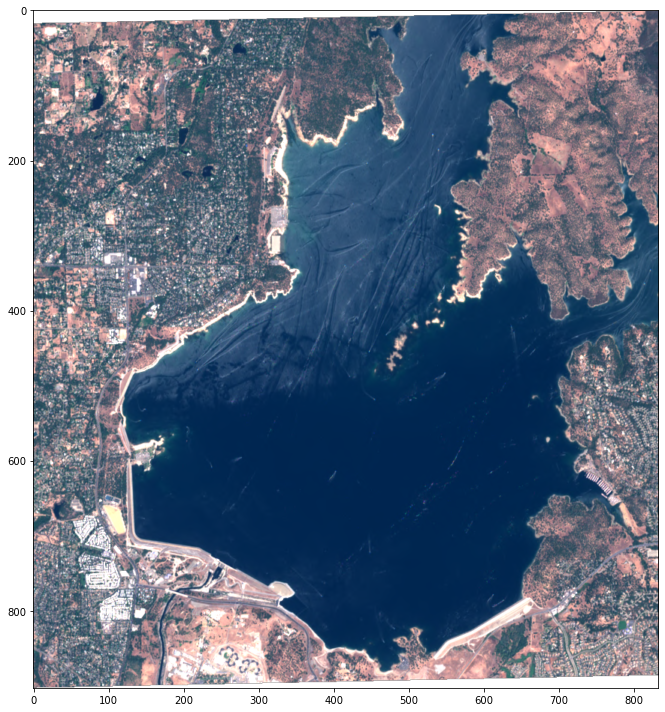

In [13]:
%matplotlib inline
dl.scenes.display(a)

## Programmatic Data Access
___________

Scenes allows programatic access to imagery. That means we can easily specify the parameters of our images and change them with minimal work. For example, if we are interested in retrieving our imagery at a different resolutions, we can just change the matching parameter in the GeoContext. Resampling is controlled by the resampler keyword argument in the [ndarray](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html#descarteslabs.scenes.scene.Scene.ndarray) method, and defaults to nearest neighbors. We might be interested in downsampling our scenes when we want to access imagery over large areas of interest and we don't need the full resolution. 

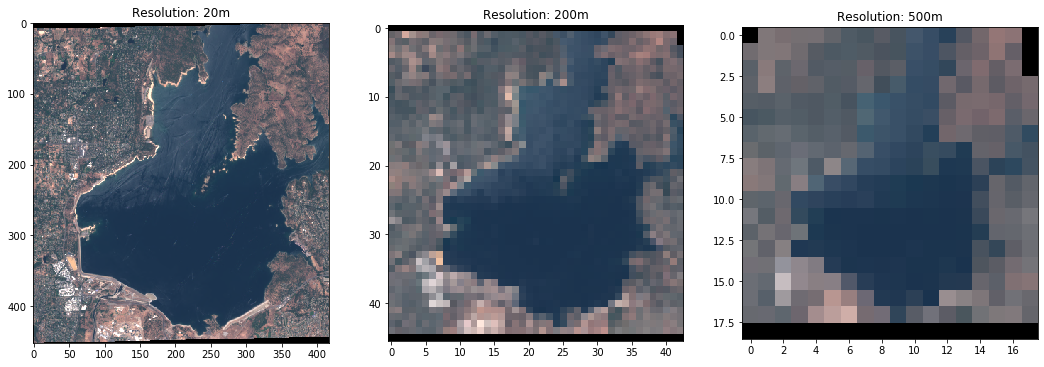

In [14]:
import matplotlib.pyplot as plt
arrays = []
resolution = [20, 200, 500]
for res in resolution:
    # assignment yields a new geocontext with the modified property
    ctx = ctx.assign(resolution=res)
    a = scenes[0].ndarray(
        bands='red green blue',
        ctx=ctx,
        bands_axis=-1,
        scaling=[(0, 2500)] * 3
    )
    arrays.append(a)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i in range(3):
    ax[i].imshow(arrays[i])
    ax[i].set_title('Resolution: {}m'.format(resolution[i]))

We can also pull our imagery with different band combinations. We can find the list of bands under the `properties.bands` field of each scene. In this case we can see that the Sentinel-2 satellite has a wide variety of visual, infrared, and thermal bands. 

In [15]:
# print available bands for this scene:
scenes[0].properties.bands.keys()

dict_keys(['derived:bai', 'derived:evi', 'derived:nbr', 'derived:ndvi', 'derived:ndwi', 'derived:ndwi1', 'derived:ndwi2', 'derived:rsqrt', 'derived:visual_cloud_mask', 'alpha', 'blue', 'bright-mask', 'cirrus', 'cirrus-cloud-mask', 'cloud-mask', 'coastal-aerosol', 'green', 'nir', 'opaque-cloud-mask', 'red', 'red-edge', 'red-edge-2', 'red-edge-3', 'red-edge-4', 'swir1', 'swir2', 'water-vapor'])

Let's visualize a few band combinations. The most familiar is the visual red, green, blue bands. Near infrared, *nir*, is often used to identify vegetation. Finally the thermal bands *swir1* and *swir2* are often used to identify hotspots such as wildfires or flares. 

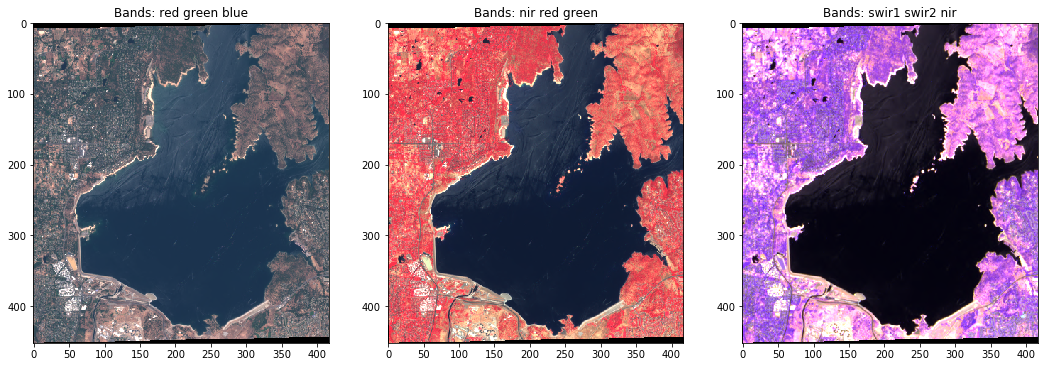

In [16]:
arrays = []
ctx = ctx.assign(resolution=20)
bands = ['red green blue', 'nir red green', 'swir1 swir2 nir']
for b in bands:
    a = scenes[0].ndarray(
        bands=b,
        ctx=ctx,
        bands_axis=-1,
        scaling=[(0, 2500)] * 3
    )
    arrays.append(a)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i in range(3):
    ax[i].set_title('Bands: {}'.format(bands[i]))
    ax[i].imshow(arrays[i])

Finally, let's look at the same scene, but over a couple of different sensors. Each satellite has different types of sensors for different types of analysis.

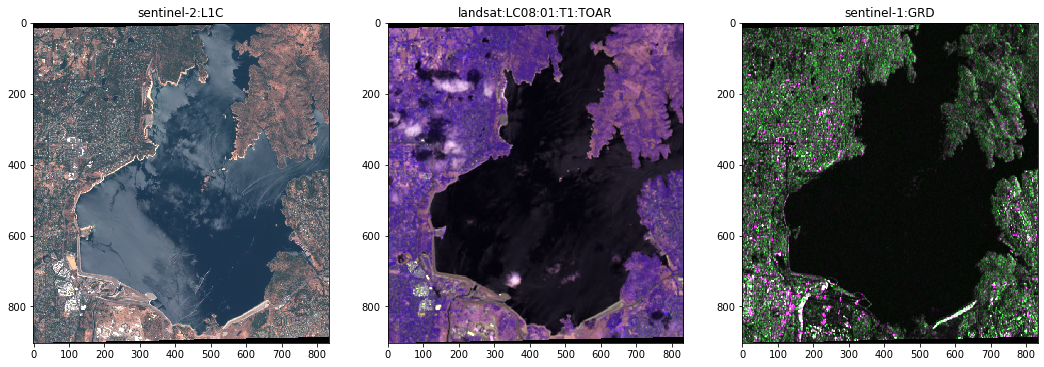

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
products = ['sentinel-2:L1C', 'landsat:LC08:01:T1:TOAR', 'sentinel-1:GRD']
bands = ['red green blue', 'swir1 swir2 nir', 'vv vh vv']
scaling = [[(0, 2500)] * 3, [(0, 5000)] * 3, None]
for i in range(3):
    s, ctx = dl.scenes.search(feature, products[i], start_datetime='2018-06-01', end_datetime='2018-06-30')
    ctx = ctx.assign(resolution=10)
    ax[i].imshow(s.mosaic(bands=bands[i], ctx=ctx, bands_axis=-1, scaling=scaling[i]))
    ax[i].set_title(products[i])

One of the strengths of Scenes is that it is very easy to retrieve a wide variety of spatial data from dozens of sources.

## Wrap Up
__________________

In this notebook we have implemented a simple water masking algorithm. In the process we have:

* Used [scenes.search](https://docs.descarteslabs.com/descarteslabs/scenes/docs/search.html) to find matching images over a region of interest.
* Used [scenes.ndarray](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html#descarteslabs.scenes.scene.Scene.ndarray) to get the pixels for any given scene.
* Access scenes with a wide variety of parameters on the fly.

## Resources
________________________

[1] [Sentinel-2 product](https://catalog.descarteslabs.com/?/product/sentinel-2:L1C)

[2] [Scenes API Documentation](https://docs.descarteslabs.com/descarteslabs/scenes/readme.html)
